# Likelihood

## Random samples generation

We want to generate $N$ **homoscedastic** (with the same $\sigma$) values normaly distributed. 

We assume also that each random number, represents a gaussian measurment with the same $\sigma$ of the normal distribution we use for generate the values.

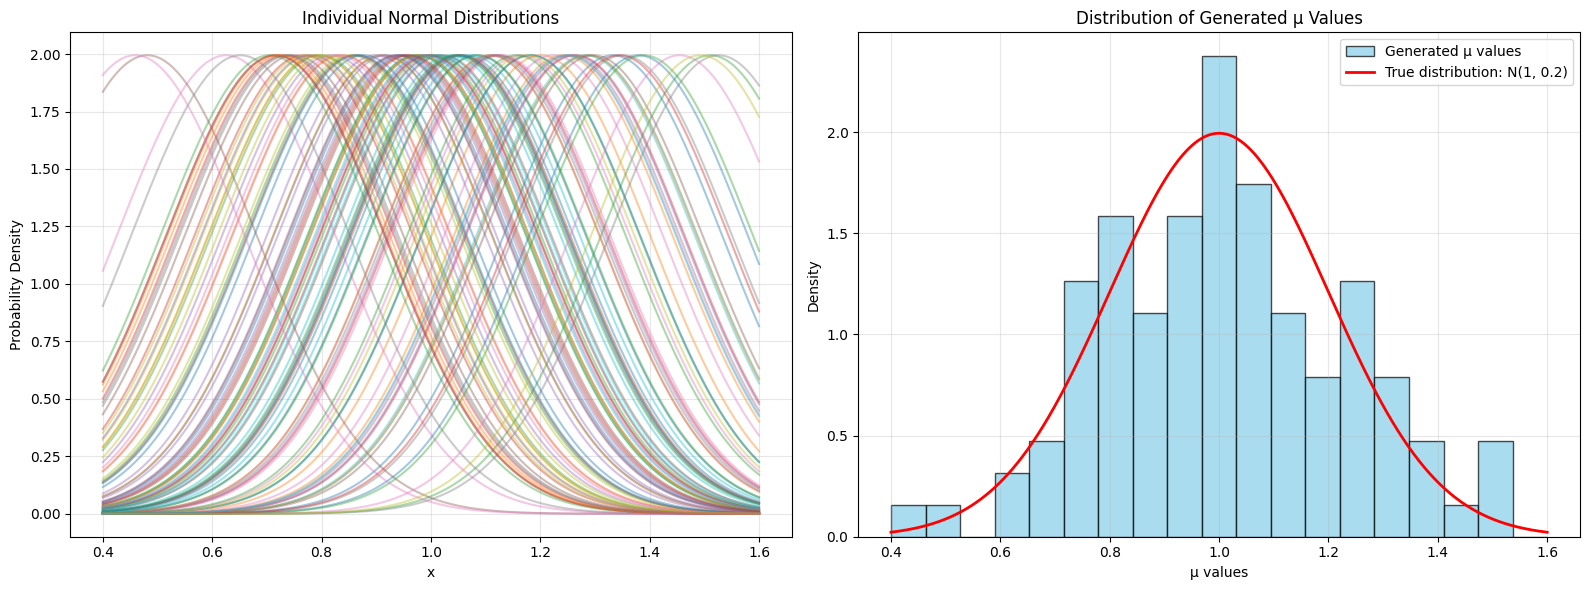

In [17]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

n_measurement = 100  
mu = 1  
sigma = 0.2  

n_of_sigma = 3
# Generate random centers for our distributions
centers = [random.gauss(mu, sigma) for _ in range(n_measurement)]
x_values = np.linspace(mu - n_of_sigma * sigma, mu + n_of_sigma * sigma, 1000)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Individual distributions
likelihoods = [] # vector of functions
for mu_simulated in centers:
    # Create a normal distribution centered at mu_simulated
    likelihood = norm(mu_simulated, sigma)
    likelihoods.append(likelihood)
    
    y = likelihood.pdf(x_values)
    ax1.plot(x_values, y, alpha=0.4) 

ax1.set_xlabel("x")
ax1.set_ylabel("Probability Density")
ax1.set_title("Individual Normal Distributions")
ax1.grid(True, alpha=0.3)

# Second subplot: Histogram of centers with true distribution
bins = np.linspace(mu - n_of_sigma * sigma, mu + n_of_sigma * sigma, 20)  # Define reasonable bins
ax2.hist(centers, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black', label='Generated μ values')

# Overlay the true distribution
x_range = np.linspace(mu - 3*sigma, mu + 3*sigma, 1000)
true_dist = norm(mu, sigma).pdf(x_range)
ax2.plot(x_range, true_dist, 'r-', linewidth=2, label=f"True distribution: N({mu}, {sigma})")

ax2.set_xlabel("μ values")
ax2.set_ylabel("Density")
ax2.set_title("Distribution of Generated μ Values")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Likelihood calculus

$$
L(\{x_i\}|\mu,\sigma) = \prod_{i=1}^NL(x_i|\mu_i,\sigma) = \prod_{i=1}^N\frac{1}{\sigma\sqrt{2\pi}}\exp\bigg(-\frac{(x_i-\mu)^2}{2\sigma^2}\bigg) = \bigg(\frac{1}{\sigma\sqrt{2\pi}}\bigg)^N\exp \bigg(-\sum_{i=1}^N\frac{(x_i-\mu)^2}{2\sigma^2} \bigg)
$$
$$
\ln(L(\{x_i\}|\mu,\sigma)) = const - \sum_{i=1}^N\frac{(x_i-\mu)^2}{2\sigma^2}
$$

We can find the maximum of the $L(\{x_i\}|\mu,\sigma)$: 
$$
\frac{dL(\mu)}{d\mu}\bigg|_{\hat{\mu}} = 0
$$
$$
\sum_{i=1}^N\frac{(x_i-\hat{\mu})}{\sigma^2} = 0
$$
$$
\Rightarrow\, \hat{\mu} = \frac{1}{N}\sum_{i=1}^Nx_i
$$

We can see that we obtain exactly the same result for the maximum of the log likelihood.

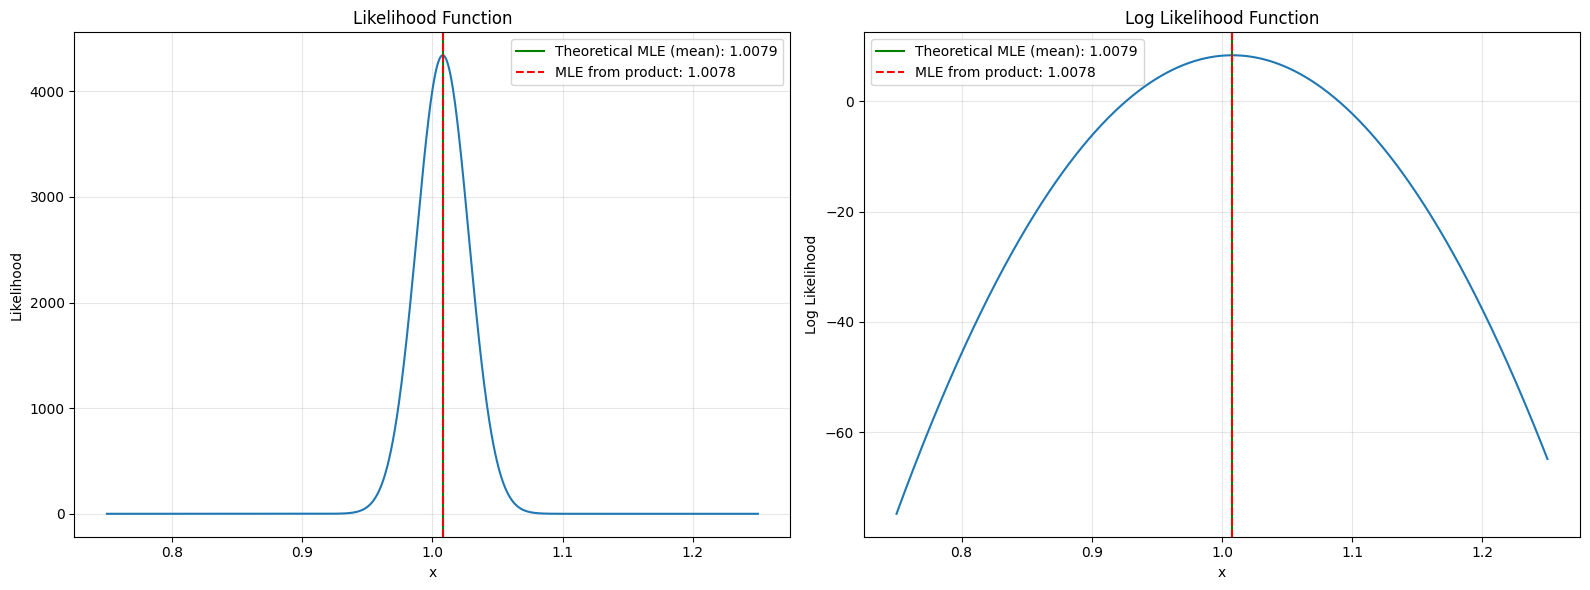

In [18]:
likelihood_values = []

x_values = np.linspace(0.75, 1.25, 1000)
for x in x_values:
    likelihood_value = 1
    for likelihood in likelihoods:
        likelihood_value *= likelihood.pdf(x)
    likelihood_values.append(likelihood_value)

log_likelihood_values = np.log(np.array(likelihood_values))

# Maximum likelihood estimate
mu_hat = np.mean(centers)
# likelihood
mu_l = x_values[np.argsort(likelihood_values)[-1]]
# log likelihood
mu_ll = x_values[np.argsort(log_likelihood_values)[-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# First subplot: Regular likelihood
ax1.plot(x_values, likelihood_values)
ax1.set_xlabel("x")
ax1.set_ylabel("Likelihood")
ax1.set_title("Likelihood Function")
ax1.grid(True, alpha=0.3)

ax1.axvline(mu_hat, color='g', linestyle='-', label=f'Theoretical MLE (mean): {mu_hat:.4f}')
ax1.axvline(mu_l, color='r', linestyle='--', label=f'MLE from product: {mu_l:.4f}')
ax1.legend()

# Second subplot: Log likelihood
ax2.plot(x_values, log_likelihood_values)
ax2.set_xlabel("x")
ax2.set_ylabel("Log Likelihood")
ax2.set_title("Log Likelihood Function")
ax2.grid(True, alpha=0.3)

ax2.axvline(mu_hat, color='g', linestyle='-', label=f'Theoretical MLE (mean): {mu_hat:.4f}')
ax2.axvline(mu_ll, color='r', linestyle='--', label=f'MLE from product: {mu_ll:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

## Fisher matrix calculus 

We have to calculate the Fisher matrix by calculating the Hessian matrix for the log likelihood, in general the equation is: 
$$
F_{jk} = -\frac{d^2\ln(L(\vec{\theta}))}{d\theta_j d\theta_k}\bigg|_{\vec{\theta} = \hat{\vec{\theta}}}
$$
In our case we have only one parameter so the Fisher matrix will be just a number and in particular it will bw the $2^{nd}$ derivate of $\ln(L(\mu))$.
$$
F = -\frac{d^2\ln(L(\mu))}{d\mu^2}\bigg|_{\mu = \hat{\mu}}
$$

From the Fisher matrix we can calculus the **covariance matrix** as: 
$$
\sigma_{jk} = F_{jk}^{-\frac{1}{2}}
$$
in our case it became:
$$
\sigma_{\mu} = \bigg(-\frac{d^2\ln(L(\mu))}{d\mu^2}\bigg|_{\mu = \hat{\mu}}\bigg)^{-\frac{1}{2}} = \bigg(\sum_{i=1}^N\frac{1}{\sigma^2}\bigg)^{-\frac{1}{2}} = \frac{\sigma}{\sqrt{N}}
$$

In **heteroscedastic** case (with different $\sigma$ for each measurment) we have a more complex expression.

In [19]:
sigma_mu_hat = sigma / np.sqrt(n_measurement)

der2_log_likelihood_values = np.diff(log_likelihood_values, n=2)
# we know that the second derivative of the log likelihood(which is a parabola) is a flat line, so we can chose a random point inside 
# the domain of the log likelihood function, for semplicity we chose the index of the first element
dx = x_values[1] - x_values[0]
fisher_matrix = -der2_log_likelihood_values[0] / (dx ** 2)
sigma_mu_ll = 1 / np.sqrt(fisher_matrix)

print(f"The standard deviation of the sample mean is {sigma_mu_hat:.8f}")
print(f"The standard deviation of the sample mean estimated from the Fisher information is {sigma_mu_ll:.8f}")

The standard deviation of the sample mean is 0.02000000
The standard deviation of the sample mean estimated from the Fisher information is 0.02000000


Is interesting to observe that in order to find the correct vlaue for the fisher matrix is necessary to divide the resul by a $dx$ therm, for normalization reasons.

We can now check whether the two normal distributions we found earlier, the first from the numerical study and the second from the theoretical approach, are similar.

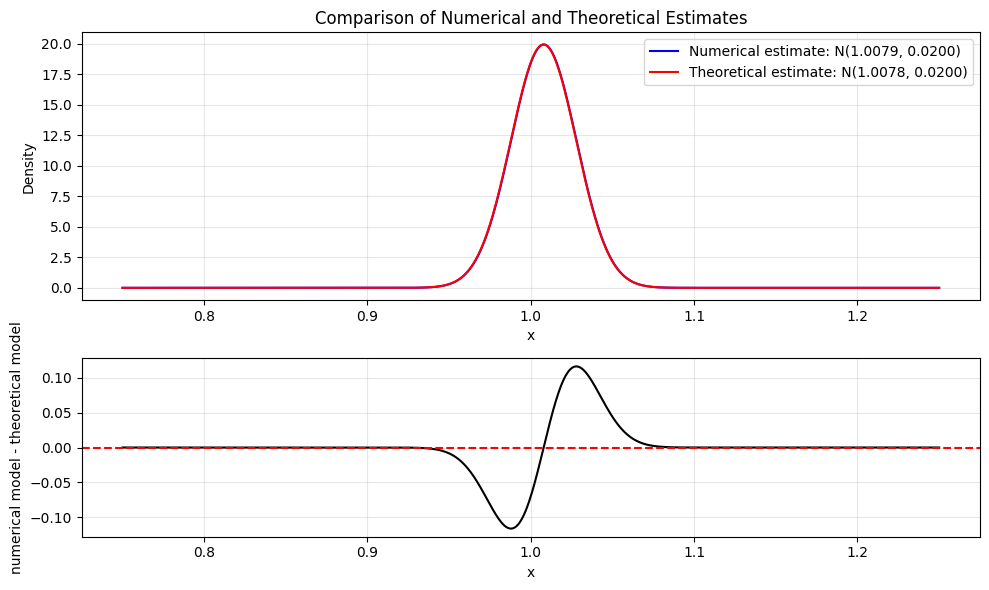

In [20]:
import matplotlib.gridspec as gridspec

gauss_numerical = norm(mu_hat, sigma_mu_hat)
gauss_theoretical = norm(mu_ll, sigma_mu_ll)

gauss_numerical_values = gauss_numerical.pdf(x_values)
gauss_theoretical_values = gauss_theoretical.pdf(x_values)

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(x_values, gauss_numerical_values, label=f"Numerical estimate: N({mu_hat:.4f}, {sigma_mu_hat:.4f})", color='blue')
ax1.plot(x_values, gauss_theoretical_values, label=f"Theoretical estimate: N({mu_ll:.4f}, {sigma_mu_ll:.4f})", color='red')
ax1.set_xlabel("x")
ax1.set_ylabel("Density")
ax1.set_title("Comparison of Numerical and Theoretical Estimates")
ax1.legend()
ax1.grid(True, alpha=0.3)

residuals = gauss_numerical_values - gauss_theoretical_values
ax2.plot(x_values, residuals, color='black', label="Residuals")
ax2.axhline(0, color='r', linestyle='--', label="Zero line")
ax2.set_xlabel("x")
ax2.set_ylabel("numerical model - theoretical model")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Heteroscedastic case

Let's build a more realistic case. 

The most important difference between the homoscedastic model is that if we compiute the maximum of the log likelihood function we don't find that the estimator is the classical mean but the weighted mean. 
$$
\frac{dL(\mu)}{d\mu}\bigg|_{\hat{\mu}} = 0
$$
$$
\sum_{i=1}^N\frac{(x_i-\hat{\mu})}{\sigma_i^2} = 0
$$
$$
\hat{\mu}\sum_{i=1}^N\frac{1}{\sigma_i^2} = \sum_{i=1}^N\frac{x_i}{\sigma_i^2}
$$
$$
\Rightarrow\, \hat{\mu} = \frac{\sum_{i=1}^N\frac{x_i}{\sigma_i^2}}{\sum_{i=1}^N\frac{1}{\sigma_i^2}}

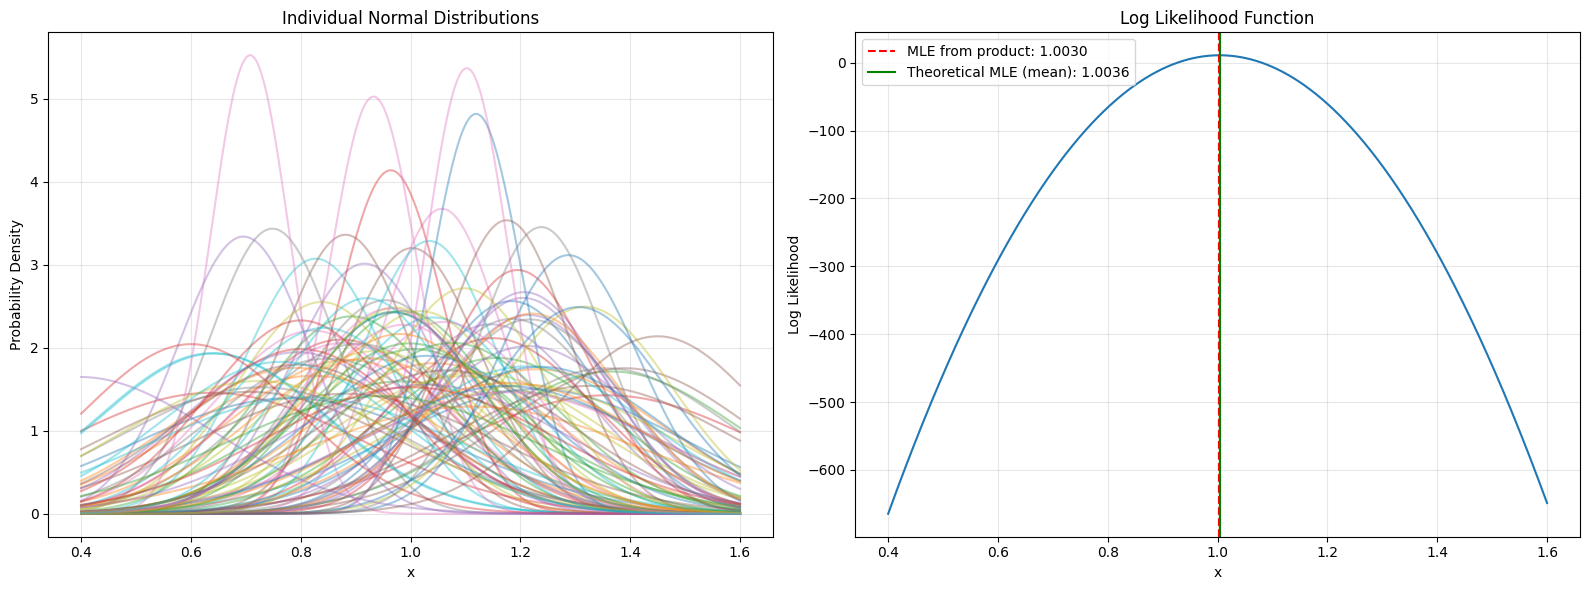

In [21]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

n_measurement = 100  
mu = 1  
sigma = 0.2  

n_of_sigma = 3
# Generate random centers for our distributions
centers = [random.gauss(mu, sigma) for _ in range(n_measurement)]
sigmas = [random.gauss(sigma, 0.05) for _ in range(n_measurement)]
x_values = np.linspace(mu - n_of_sigma * sigma, mu + n_of_sigma * sigma, 1000)

# First subplot: Individual distributions
likelihoods = []
for mu_simulated, sigma_simulated in zip(centers, sigmas):
    # Create a normal distribution centered at mu_simulated
    likelihood = norm(mu_simulated, sigma_simulated)
    likelihoods.append(likelihood)
    
likelihood_values = []
for x in x_values:
    likelihood_value = 1
    for likelihood in likelihoods:
        likelihood_value *= likelihood.pdf(x)
    likelihood_values.append(likelihood_value)

log_likelihood_values = np.log(np.array(likelihood_values))

mu_hat, wheigth = 0, 0 
for mu, sigma in zip(centers, sigmas):
    mu_hat += mu / sigma**2
    wheigth += 1 / sigma**2
mu_hat /= wheigth

mu_ll = x_values[np.argsort(log_likelihood_values)[-1]]

# plot 2 subplots one for the distribution samples and one for the log likelihood function
plt.figure(figsize=(16, 6))    
plt.subplot(1, 2, 1) 
for likelihood in likelihoods:
    y = likelihood.pdf(x_values)
    plt.plot(x_values, y, alpha=0.4)
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.title("Individual Normal Distributions")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(x_values, log_likelihood_values)
plt.xlabel("x")
plt.ylabel("Log Likelihood")
plt.title("Log Likelihood Function")
plt.grid(True, alpha=0.3)
plt.axvline(mu_ll, color='r', linestyle='--', label=f'MLE from product: {mu_ll:.4f}')
plt.axvline(mu_hat, color='g', linestyle='-', label=f'Theoretical MLE (mean): {mu_hat:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

We have now to compiute the covariance matrix using different wheights: 

$$
\sigma_{\mu} = \bigg(-\frac{d^2\ln(L(\mu))}{d\mu}\bigg|_{\mu = \hat{\mu}}\bigg)^{-\frac{1}{2}} = \bigg(\sum_{i=1}^N\frac{1}{\sigma_i^2}\bigg)^{-\frac{1}{2}} 
$$


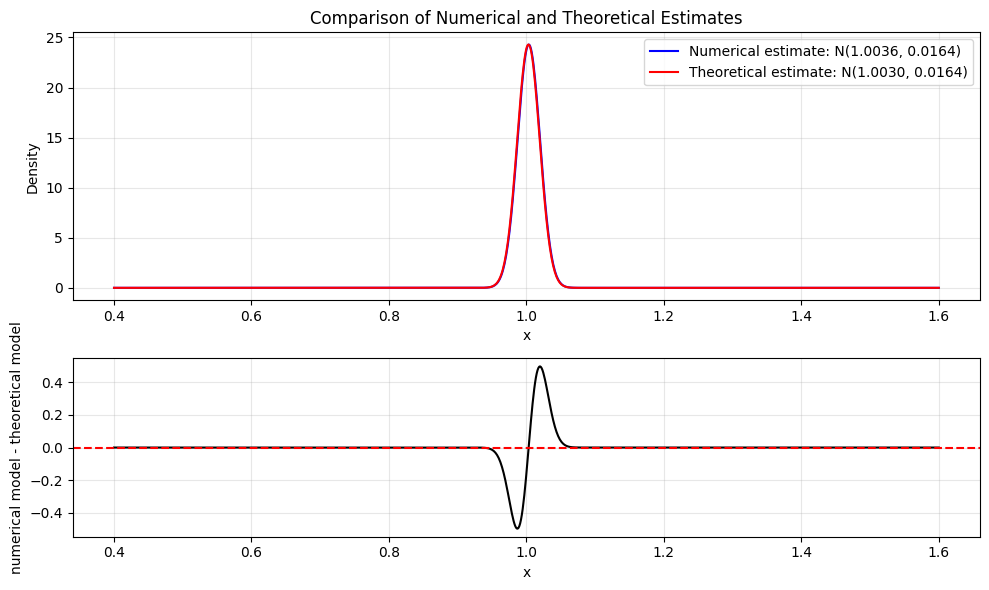

In [22]:
import matplotlib.gridspec as gridspec

sigma_mu_hat = 1 / np.sqrt(wheigth)

der2_log_likelihood_values = np.diff(log_likelihood_values, n=2)
dx = x_values[1] - x_values[0]
fisher_matrix = -der2_log_likelihood_values[0] / (dx ** 2)
sigma_mu_ll = 1 / np.sqrt(fisher_matrix)

gauss_numerical = norm(mu_hat, sigma_mu_hat)
gauss_theoretical = norm(mu_ll, sigma_mu_ll)

gauss_numerical_values = gauss_numerical.pdf(x_values)
gauss_theoretical_values = gauss_theoretical.pdf(x_values)

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(x_values, gauss_numerical_values, label=f"Numerical estimate: N({mu_hat:.4f}, {sigma_mu_hat:.4f})", color='blue')
ax1.plot(x_values, gauss_theoretical_values, label=f"Theoretical estimate: N({mu_ll:.4f}, {sigma_mu_ll:.4f})", color='red')
ax1.set_xlabel("x")
ax1.set_ylabel("Density")
ax1.set_title("Comparison of Numerical and Theoretical Estimates")
ax1.legend()
ax1.grid(True, alpha=0.3)

residuals = gauss_numerical_values - gauss_theoretical_values
ax2.plot(x_values, residuals, color='black', label="Residuals")
ax2.axhline(0, color='r', linestyle='--', label="Zero line")
ax2.set_xlabel("x")
ax2.set_ylabel("numerical model - theoretical model")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()